## Basics

Before building micrograd and a neural network it is important to understand what is a neural network and understand some concepts such as derivatives.

A neural network is in simple terms a computer algorithm that is attempting to mimic the working of a human brain.

Lets now understand the concept of a derivative.

In [153]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
# Lets define a function f

def f(x):
    return 5*x**2 - 6*x + 2

In [155]:
f(3)

29

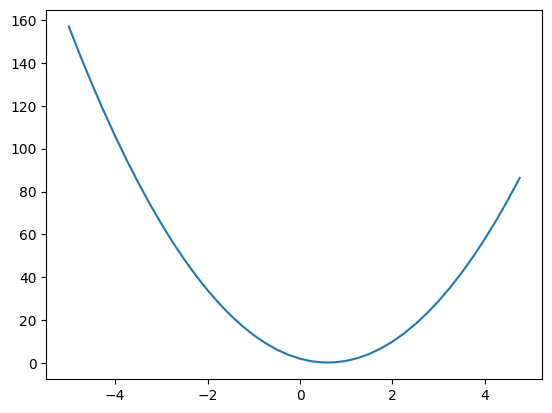

In [156]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

When we talk about the derivative of the function in mathematics we represent it in a symbolic way by solving the expression taking it with respect to x. In the above case this would be 

$$\frac{df(x)}{dx} = 10x + 3$$

However for entire neural networks we do not display it like this as a symbolic represnetation would be very complex and would take very long to solve. Hence we yet find the derivative but not by solving it in the fsymbolic way, rather we can understand the concept of derivative by using the above plot.

Derivative is basically if we have a point x on our graph and we increase x by amount h, the sensitivity by which the function reacts can be found by using the derivative, this number is represented by the derivative of the slope at that point, slope can be positive or negative, negative means f(x) is reducing, positive means f(x) is increasing. Equation is given by:

$$ L = \lim_{h \to 0}\frac{f(a+h) -f(a)}{h} $$

In the above expression a can be substituted as a and h is the change.

We will now write this in code, h tends to 0 so we will take a very small value

In [157]:
x = 3.0
h = 0.001

In [158]:
f(x)

29.0

In [159]:
# Lets see how f changes when we add term h
print(f(x+h))
print((f(x + h) - f(x)) / h)

29.024004999999995
24.00499999999539


Therefore by slightly increasing x in a positive direction can see that f has increased and it has increased by 0.33. We can intuitvely see this by looking at the graph and we can see that at point 3 on x axis if we increase i.e. we move in a positive direction value of y will also increase. In reality we need a much smaller value of h to converge to the correct answer however if you increase it and have too many 0 after decimal point it will give an incorrect answer this is because of floating point arithmetic, computers store these numbers and too many floating point digits can cause error.

In [160]:
x = 3.0
h = 0.00000001
print(f(x+h))
print((f(x + h) - f(x)) / h)

29.00000024
23.999999854140697


In [161]:
x = 0.58
h = 0.00000001
print(f(x+h))
print((f(x + h) - f(x)) / h)

0.20199999800000046
-0.1999999943436137


As you can see slope is almost reaching 0, when slope reaches 0 it means that a slight nudge at this point makes no difference to the function and it does not respond to the change.

In [162]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [163]:
def f2(a,b,c):
    return a*b +c

In [164]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

# No updates
d = f2(a,b,c)

# By updating a,b,c alone
d1 = f2(a+h,b,c)
d2 = f2(a,b+h,c)
d3 = f2(a,b,c+h)

print(f'No updates: {d}')
print(f'Updating a: {d1}')
print(f'Slope ((d1-d) / h) : {(d1-d)/h}')

print(f'Updating b: {d2}')
print(f'Slope ((d2-d) / h) : {(d2-d)/h}')

print(f'Updating c: {d3}')
print(f'Slope ((d3-d) / h) : {(d3-d)/h}')

No updates: 4.0
Updating a: 3.999699999999999
Slope ((d1-d) / h) : -3.000000000010772
Updating b: 4.0002
Slope ((d2-d) / h) : 2.0000000000042206
Updating c: 4.0001
Slope ((d3-d) / h) : 0.9999999999976694


Intuitively as expected since a is positively increasing and b is negative by multiplying we are reducing the value of d overall. As far as slope is concerned when we find it with respect to 'a', the derivative of the function with respect to 'a' will give us constant 'b', where value is -3 so this is indeed correct.

## Building micrograd

Now that we know the bare basics of derivatives and how they work we will begin the process to build our network. To start off we first need to create a way to handle our expressions. Above our expression was $$a \times b + c$$, neural networks are representations of such expressions, so we need to create a way to handle them, we will do this by creating a class Value, given below, and we must create it in such a way that we can perform arithmetic operations and represent our expression properly.

In [165]:
class Value:
    # Initialise values of class
    def __init__(self, data, _children=(), _op='', label=' ') -> None:
        # Actual value of node
        self.data = data

        # To track the previous values that resulted in current value
        self._prev = set(_children)

        # To track operation that resulted in current value ('' default for leaf nodes)
        self._op = _op

        # Label of variable
        self.label = label
    
    # Returns a printable representation of object
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    # Add two objects
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    # Multiply two objects
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [166]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [167]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

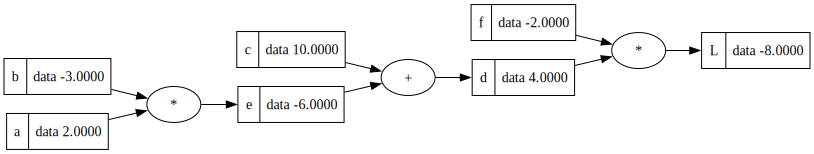

In [168]:
draw_dot(L)

Looking at this graph above we can see that this is a forward pass, where the mathematical expression ultimately evaluates to give us the value of -8.0. This is a key concept of neural networks. As of now we have only looked into evaluating these simple mathematical expressions which are scalar in nature but this is the concept upon which neural networks are built, the next task is to implement backpropogration in the Value class. 

Backpropogation as the name suggests moves backward, we start at node L and move back to node a and b, it is used to find the derivative of each node with respect to node L, so for L itself it will be 1 then we find the derivative of L with respect to d, f, e and so on. This derivative is the gradient, that is we are trying to find what effect the variable has on the function, that is by changing the variable how much does the function change. Usually the values we derive with are not data but rather they are the weights of the neural network, which are iterated on, we find the derivative of the Loss function with respect to these weights in order to find out how to update the weights incrementally to optimise the loss function.

We will now update the value class to work with backpropogration.

In [169]:
class Value:
    # Initialise values of class
    def __init__(self, data, _children=(), _op='', label=' ') -> None:
        # Actual value of node
        self.data = data

        # Keep track of gradient (initially assumed to not affect the function)
        self.grad = 0.0

        # To track the previous values that resulted in current value
        self._prev = set(_children)

        # To track operation that resulted in current value ('' default for leaf nodes)
        self._op = _op

        # Label of variable
        self.label = label
    
    # Returns a printable representation of object
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    # Add two objects
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    # Multiply two objects
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [170]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [171]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

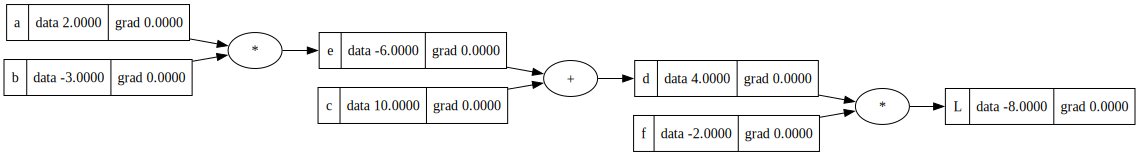

In [172]:
draw_dot(L)

We wil now manually calculate the value of the gradients we will first do this by creating a function to measure the change in L if we change the value of input by increasing it by some value h, this can also be done by simply calculating the derivative of L with respect to that variable.

In [173]:
def change_in_l():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d * f
    L.label = 'L'
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    a.data += h
    e = a*b
    e.label = 'e'
    d = e + c
    # Finding with respect to by increasing d by h
    #d.data += h
    d.label = 'd'
    f = Value(-2.0, label='f')
    L2 = d * f
    L.label = 'L'

    diff = L2.data - L1.data
    # Gradient
    print((diff)/h)

In [174]:
change_in_l()

6.000000000000227


This is as expected as the value of f is -2.0, we are getting the value of f as the value of gradient as we calculate dL/dd that is derivative of d*f with respect to d then symbolically the result is f since f is the constant, we will use this concept to now find the values of the other variables.

$L = d * f$

$dL/dd = ? = f$

$(f(x+h) - f(x)) / h$

$=((d+h)*f - d*f) / h$

$=(d*f + f*h - d*f) / h$

$=f*h/h$

$=f$

In [175]:
f.grad = 4.0
d.grad = -2.0

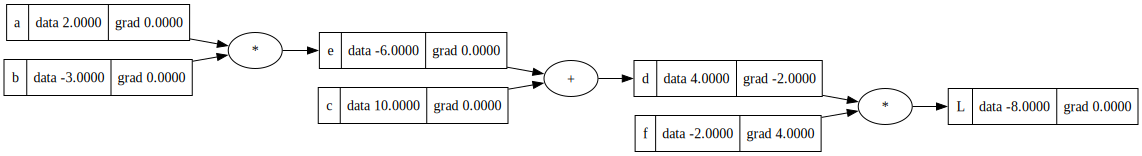

In [176]:
draw_dot(L)

Now when we want to find gradient of c it is more complicated, this is because c is two steps away from L, to find how it affects L we need to see how it affects d and then how d affects L, therefore there is an intermediate step between c and L, to solve this we can use the concept of chain rule

f = c + e
dc/dd = 1
de/dd = 1

FIND:
dL/dc

HAVE:
dL/dd
dc/dd

METHOD:
dL/dc = dL/dd * dc/dd (chain rule)

dL/dc = -2.0 * 1
dL/de = -2.0 * 1

In [177]:
c.grad = -2.0
e.grad = -2.0

These results can once again be verified by using the change_in_l function.

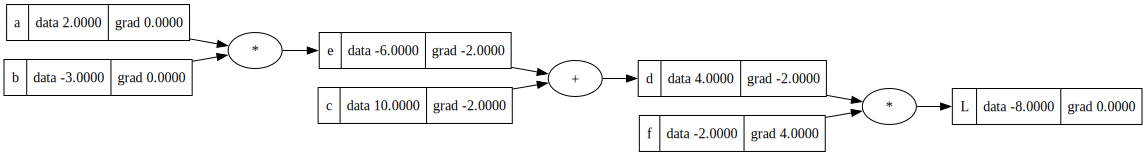

In [178]:
draw_dot(L)

f = a*b
da/de = -3.0
db/de = 2.0

FIND:
dL/da
dL/db

HAVE:
dL/de
da/de
db/de

METHOD:
dL/da = dL/de * da/de (chain rule)
dL/db = dL/de * db/de (chain rule)

dL/da = -3.0 * -6.0
dL/db = 2.0 * -6.0

In [181]:
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

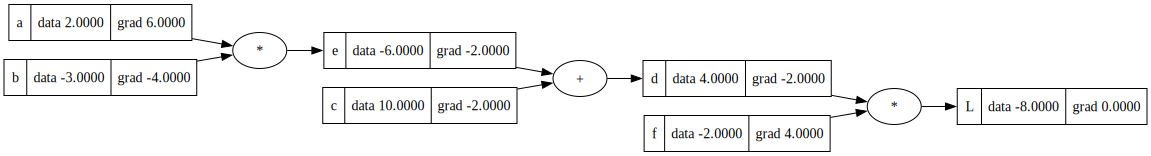

In [182]:
draw_dot(L)

It is important to remember that we are always at a node finding the local gradient for example da/de which is the local gradient as that node has no idea about the greater network, and backpropogation is essentially a recursive application of the chain rule as we need to find how the variable can affect output which is done by using chain rule to find how it affects the intermediate variables as well which in turn affects the final output.